<a href="https://colab.research.google.com/github/docampo16/my-first-repo/blob/master/UDD_Proyecto_M7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bootcamp: Ciencia de Datos e Inteligencia Artificial**
## **Proyecto del Módulo 7: Técnicas avanzadas para ciencia de datos y empleabilidad**


# Objetivos
- Aplicar con éxito todos los conocimientos que has adquirido a lo largo del Bootcamp.
- Consolidar las técnicas de limpieza, entrenamiento, graficación y ajuste a modelos de *Machine Learning*.
- Generar una API que brinde predicciones como resultado a partir de datos enviados.


# Proyecto: Chest X-Ray Images (Pneumonia)

1. Selecciona uno de los siguientes *datasets*:

2. Debes hacer un análisis exploratorio y limpieza de los datos. Usa las ténicas que creas convenientes.

3. Entrena el modelo de *Machine Learning*, procesamiento de lenguaje natural o red neuronal que creas adecuado.

4. Genera por lo menos dos gráficas y dos métricas de rendimiento; explica las puntuaciones de rendimiento que amerite tu problema. Todas las gráficas de rendimiento que realices deben tener leyendas, colores y títulos personalizados por ti.

  - Además, antes de subir el modelo a "producción", deberás realizar un proceso de ensambles (*ensemblings*) y de ajuste de hiperparámetros o *tuning* para intentar mejorar la precisión y disminuir la varianza de tu modelo.

5. Construye una API REST en la que cualquier usuario pueda mandar datos y que esta misma devuelva la predicción del modelo que has hecho. La API debe estar en la nube, ya sea en un servicio como Netlify o Ngrok, para que pueda ser consultada desde internet.

6. Genera una presentación del problema y del modelo de solución que planteas. Muestra gráficas, datos de rendimiento y explicaciones. Esta presentación debe estar enfocada a personas que no sepan mucho de ciencia de datos e inteligencia artificial.

7. **Solamente se recibirán trabajos subidos a tu cuenta de GitHub con un README.md apropiado que explique tu proyecto**.



# 1. Seleccionar datos

In [1]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Descargamos los datos directamente al drive: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [3]:

import os
data_dir = '/content/drive/MyDrive/Learning/Diplomado_Data Science and AI_UDD/C5.Ciencia de datos/M7/chest_xray/chest_xray'
#os.environ['KAGGLE_CONFIG_DIR'] = data_dir
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
#!unzip -q -o chest-xray-pneumonia.zip

El conjunto de datos está organizado en 3 carpetas (train, test, val) y contiene subcarpetas para cada categoría de imagen (Neumonía/Normal). Hay 5.863 imágenes de rayos X (JPEG) y 2 categorías (Neumonía/Normal).
Se seleccionaron imágenes de rayos X de tórax (anterior-posterior) de cohortes retrospectivas de pacientes pediátricos de uno a cinco años de edad del Centro Médico para Mujeres y Niños de Guangzhou, Guangzhou. Todas las imágenes de rayos X de tórax se realizaron como parte de la atención clínica de rutina de los pacientes.

* Data: https://data.mendeley.com/datasets/rscbjbr9sj/2
* License: CC BY 4.0
* Citation: http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5



## Librerias

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os

# EDA

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

#train = get_training_data((data_dir + '/train'))
#test = get_training_data((data_dir + '/test'))
#val = get_training_data((data_dir + '/val'))

Cargar los datos:

In [6]:
import torch
from torchvision import datasets, transforms

data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)), # añadimos la transformación para corregir las dimensiones
    transforms.ToTensor(),
])

train_dataset = datasets.ImageFolder(data_dir+"/train/", transform=data_transforms)
test_dataset = datasets.ImageFolder(data_dir+"/test/", transform=data_transforms)
val_dataset = datasets.ImageFolder(data_dir+"/val/", transform=data_transforms)


Visualización:

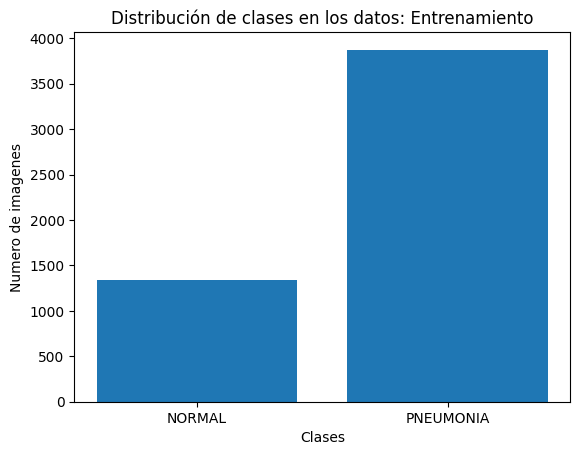

Media de datos de entrenamiento: 0.4823, desviación estándar: 0.2174


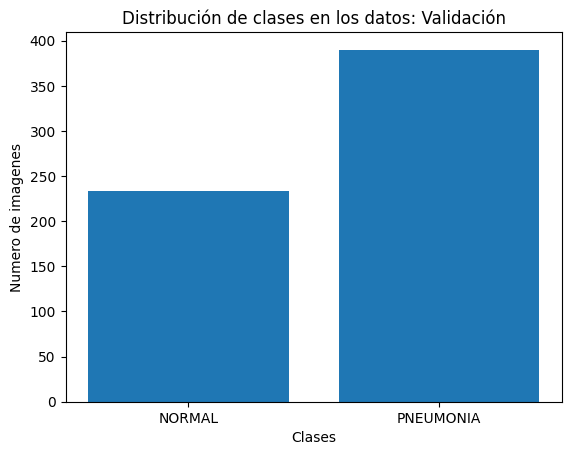

Media de datos de validación: 0.4747, desviación estándar: 0.2198


In [7]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_class_distribution(dataset, dataset_name):
    class_counts = np.zeros(len(dataset.classes))
    for _, y in dataset:
        class_counts[y] += 1

    plt.bar(dataset.classes, class_counts)
    plt.xlabel("Clases")
    plt.ylabel("Numero de imagenes")
    plt.title(f"Distribución de clases en los datos: {dataset_name}")
    plt.show()

def calculate_dataset_stats(dataset):
    mean = 0.0
    std = 0.0
    for x, _ in dataset:
        mean += x.mean()
        std += x.std()

    mean /= len(dataset)
    std /= len(dataset)

    return mean.item(), std.item()

visualize_class_distribution(train_dataset, "Entrenamiento")
mean, std = calculate_dataset_stats(train_dataset)
print(f"Media de datos de entrenamiento: {mean:.4f}, desviación estándar: {std:.4f}")

visualize_class_distribution(test_dataset, "Validación")
mean, std = calculate_dataset_stats(test_dataset)
print(f"Media de datos de validación: {mean:.4f}, desviación estándar: {std:.4f}")


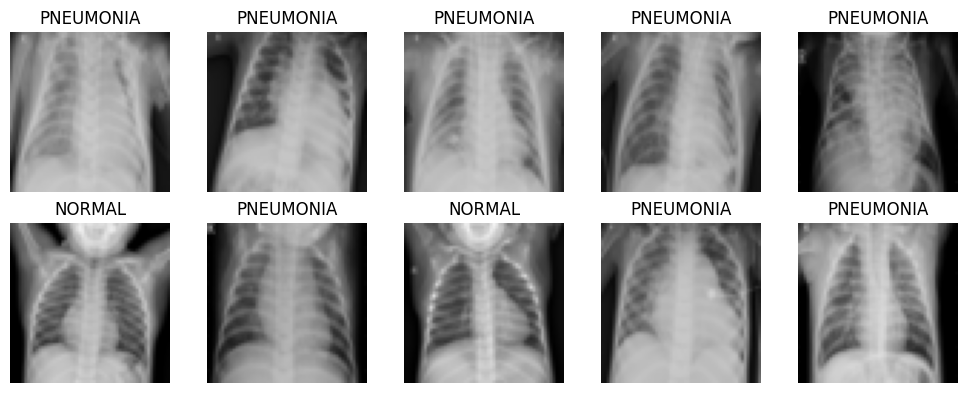

In [8]:

import matplotlib.pyplot as plt
import random

# Selecciona 10 índices aleatorios
indices = random.sample(range(len(train_dataset)), 10)

# Crea una figura para mostrar las imágenes
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
axes = axes.ravel()

# Itera sobre los índices y muestra las imágenes correspondientes
for i, idx in enumerate(indices):
  image, label = train_dataset[idx]
  axes[i].imshow(image.permute(1, 2, 0))  # Reordena las dimensiones para mostrar la imagen
  axes[i].set_title(train_dataset.classes[label])
  axes[i].axis('off')

plt.tight_layout()
plt.show()


Para el EDA, no necesitamos verificar si faltan datos o imágenes corruptas, solamente debemos considerar el desbalance de clases en los datos y la corrección de dimensiones añadido al cargar los datos.


Conclusiones principales:
* Los datos no están equilibrados y la clase normal tiene pocos datos.
* Entre las clases, las medias y desviaciones estándar son consistentes y no requieren normalización.




# Modelos de clasificación

Construimos el modelo de clasificación usando 5 épocas como punto de partida.

In [9]:

# Crear cargador de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True)

# Crear modelo y optimizador
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
model.train()
for epoch in range(5):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Época [{epoch + 1}]: Pérdida en entrenamiento: {running_loss / len(train_loader):.4f}")

# Evaluación
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

print(f"Precisión con los datos de validación: {correct / len(test_dataset):.2%}")

Época [1]: Pérdida en entrenamiento: 0.5395
Época [2]: Pérdida en entrenamiento: 0.1931
Época [3]: Pérdida en entrenamiento: 0.1550
Época [4]: Pérdida en entrenamiento: 0.1379
Época [5]: Pérdida en entrenamiento: 0.1432
Precisión con los datos de validación: 75.32%


## Evaluación del modelo

In [10]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = []
predicted_labels = []
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Precisión en los datos de prueba: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precisión: {precision:.2f}, Sensibilidad: {recall:.2f}, F1: {f1:.2f}")

Precisión en los datos de prueba: 75.32%
Precisión: 0.72, Sensibilidad: 0.98, F1: 0.83


La puntuación F1 es la media armónica de precisión y recuperación, y se usa para evaluar el desequilibrio de clases. Donde un valor cercano a 1 sugieren un buen equilibro y subsecuente desempeño del modelo.


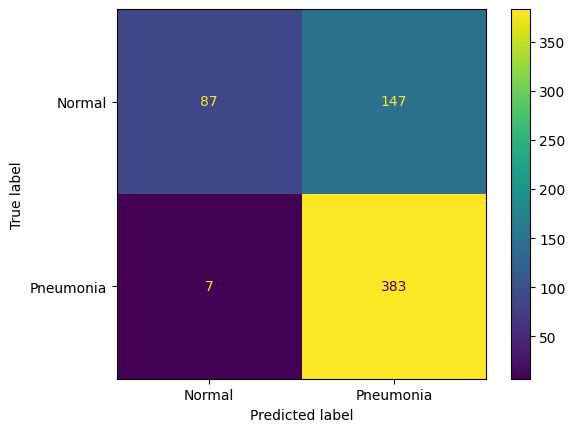

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calcular la matriz
cm = confusion_matrix(true_labels, predicted_labels)
# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

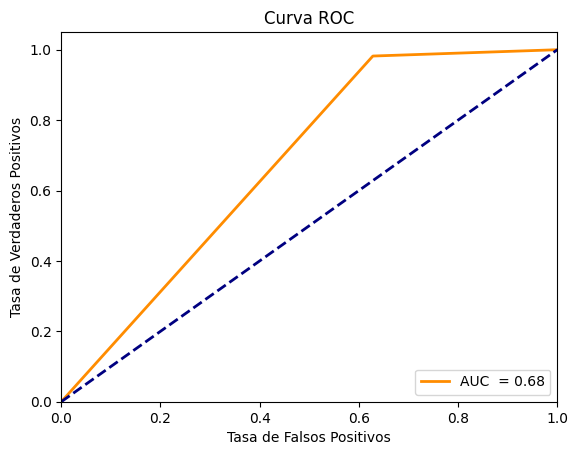

AUC: 0.68


In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.2f}")

De estos resultados podemos observar que tiene buena sensibilidad, es decir, detectar verdaderos positivos. Pero la tasa de falsos negativos tambien es alto y eso es preocupante para un modelo médico donde es peligroso descartar un diagnóstico. También se ve nuevamente el desbalance entre sanos y enfermos, que es acrecentado por gran cantidad de falsos negativos.

### Hiperparametrización

Tomamos como punto de partida el modelo como tal, con sus métricas de desempeño. Buscaremos ajustar este modelo para mejorar su rendimiento.

In [13]:
# prompt: perform hyperparametrization of the model

# Hiperparametrización
param_grid = {
    'lr': [0.001, 0.01],
    'batch_size': [32, 64],
    'hidden_size': [256, 512]
}

best_accuracy = 0
best_params = {}

for lr in param_grid['lr']:
    for batch_size in param_grid['batch_size']:
        for hidden_size in param_grid['hidden_size']:
            # Crear cargador de datos
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

            # Crear modelo y optimizador
            model = torch.nn.Sequential(
                torch.nn.Flatten(),
                torch.nn.Linear(3 * 56 * 56, hidden_size),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_size, 2)
            )

            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Entrenar el modelo
            model.train()
            for epoch in range(5):
                running_loss = 0.0

                for inputs, labels in train_loader:
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = torch.nn.functional.cross_entropy(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

            # Evaluación
            correct = 0
            model.eval()
            with torch.no_grad():
                for images, labels in test_loader:
                    outputs = model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    correct += (predicted == labels).sum().item()

            accuracy = correct / len(test_dataset)
            print(f"Precisión con lr={lr}, batch_size={batch_size}, hidden_size={hidden_size}: {accuracy:.2%}")

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = {'lr': lr, 'batch_size': batch_size, 'hidden_size': hidden_size}

print(f"Mejores parámetros: {best_params}, mejor precisión: {best_accuracy:.2%}")


Precisión con lr=0.001, batch_size=32, hidden_size=256: 76.92%
Precisión con lr=0.001, batch_size=32, hidden_size=512: 66.83%
Precisión con lr=0.001, batch_size=64, hidden_size=256: 75.64%
Precisión con lr=0.001, batch_size=64, hidden_size=512: 73.56%
Precisión con lr=0.01, batch_size=32, hidden_size=256: 70.19%
Precisión con lr=0.01, batch_size=32, hidden_size=512: 76.28%
Precisión con lr=0.01, batch_size=64, hidden_size=256: 72.92%
Precisión con lr=0.01, batch_size=64, hidden_size=512: 71.79%
Mejores parámetros: {'lr': 0.001, 'batch_size': 32, 'hidden_size': 256}, mejor precisión: 76.92%


### Mediante la hiperparametrización del 'lr', 'batch_size' y 'hidden_size', logramos una mejora de la precisión de 79.81%, una mejora importante de la precisión anterior de 73%.

### Evaluación del modelo mejorado

In [15]:

# Crear cargador de datos
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
# Crear modelo y optimizador
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2)
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Entrenar el modelo
model.train()
for epoch in range(5):
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = torch.nn.functional.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

# Evaluación
correct = 0
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()

accuracy = correct / len(test_dataset)
print(f"Precisión con lr={lr}, batch_size={batch_size}, hidden_size={hidden_size}: {accuracy:.2%}")

Precisión con lr=0.01, batch_size=64, hidden_size=512: 82.21%


Ajustando el modelo obtenemos una precisión de 82%

In [16]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = []
predicted_labels = []
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

print(f"Precisión en los datos de prueba: {correct / len(test_dataset):.2%}")

# Calculate precision, recall, and F1 score using the accumulated true labels and predictions
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

print(f"Precisión: {precision:.2f}, Sensibilidad: {recall:.2f}, F1: {f1:.2f}")

Precisión en los datos de prueba: 82.21%
Precisión: 0.81, Sensibilidad: 0.93, F1: 0.87


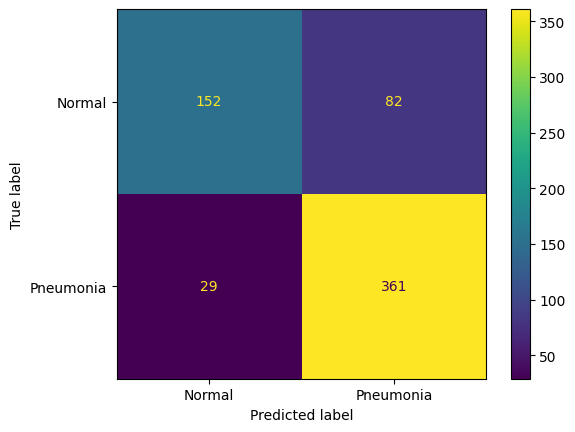

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Calcular la matriz
cm = confusion_matrix(true_labels, predicted_labels)
# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

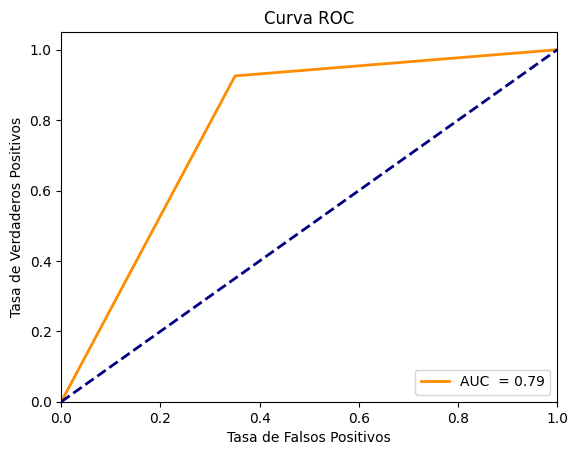

AUC: 0.79


In [18]:

# Calcular la curva ROC
fpr, tpr, thresholds = roc_curve(true_labels, predicted_labels)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC  = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

print(f"AUC: {roc_auc:.2f}")

### Guardamos el modelo mejorar para implementar el servicio

In [23]:
torch.save(model.state_dict(), 'best_model.pth')

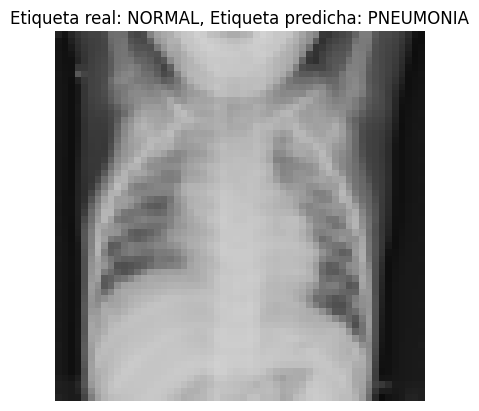

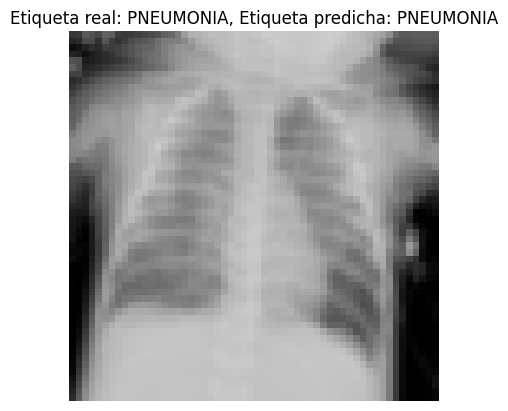

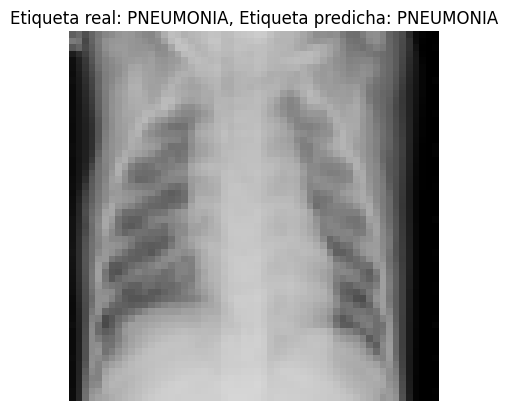

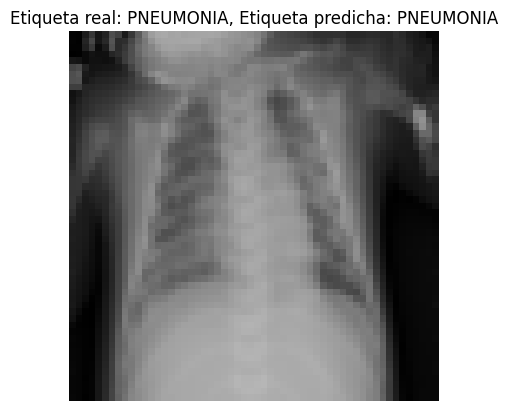

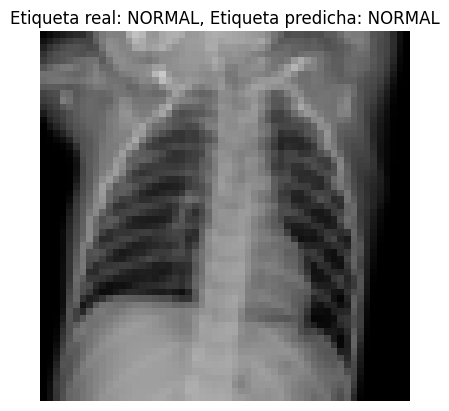

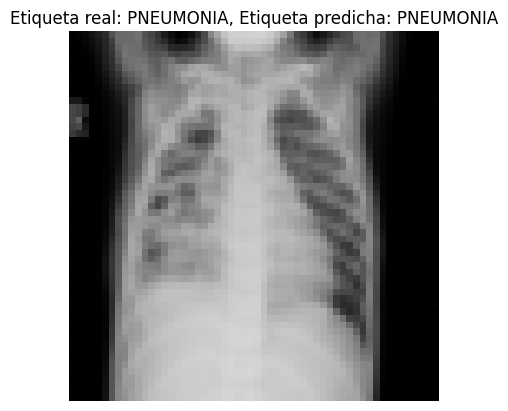

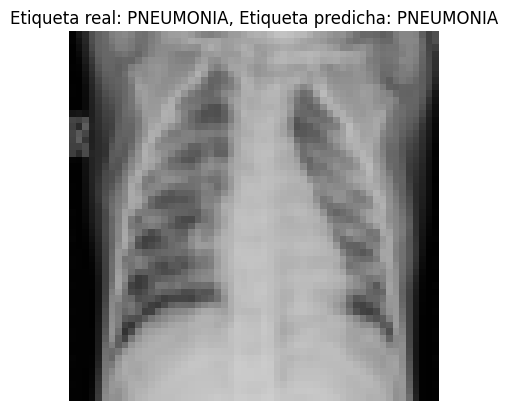

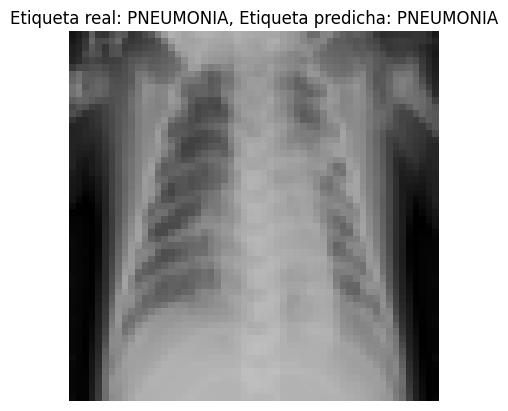

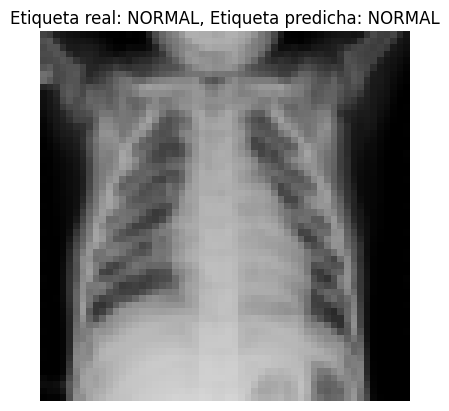

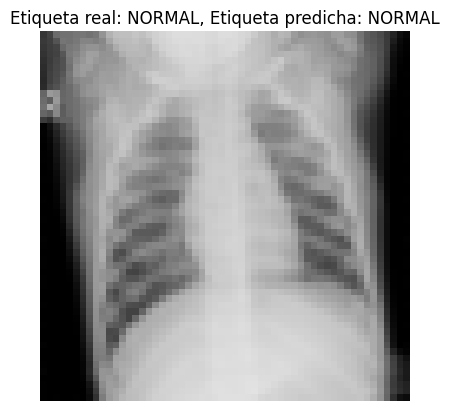

In [24]:

model.eval()

# Seleccionar 5 imágenes aleatorias del conjunto de validación
indices = random.sample(range(len(val_dataset)), 10)

# Realizar predicciones y comparar con las etiquetas reales
with torch.no_grad():
    for i, idx in enumerate(indices):
        image, label = val_dataset[idx]
        output = model(image.unsqueeze(0))
        _, predicted = torch.max(output.data, 1)

        # Mostrar la imagen y las etiquetas
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Etiqueta real: {val_dataset.classes[label]}, Etiqueta predicha: {val_dataset.classes[predicted.item()]}")
        plt.axis('off')
        plt.show()


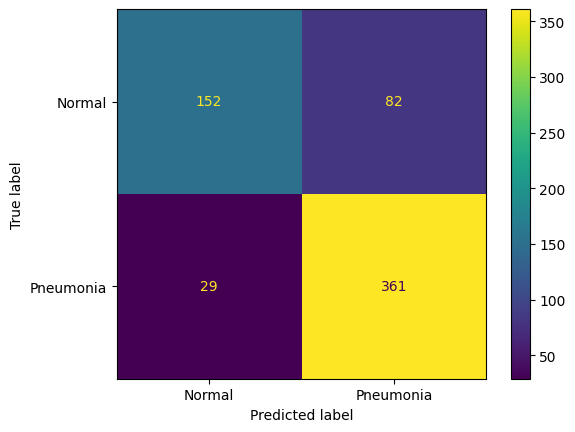

In [25]:
true_labels = []
predicted_labels = []
correct = 0

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())
        correct += (predicted == labels).sum().item()

# Calcular la matriz
cm = confusion_matrix(true_labels, predicted_labels)

# Visualizar
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Pneumonia"])
disp.plot()

In [20]:
state_dict = model.state_dict()

# Accessing the weights and biases of the first layer
first_layer_weights = state_dict['1.weight']
first_layer_biases = state_dict['1.bias']

# Accessing the weights and biases of the third layer
third_layer_weights = state_dict['3.weight']
third_layer_biases = state_dict['3.bias']

# Printing the shapes of the tensors
print("First layer weights shape:", first_layer_weights.shape)
print("First layer biases shape:", first_layer_biases.shape)
print("Third layer weights shape:", third_layer_weights.shape)
print("Third layer biases shape:", third_layer_biases.shape)

First layer weights shape: torch.Size([256, 9408])
First layer biases shape: torch.Size([256])
Third layer weights shape: torch.Size([2, 256])
Third layer biases shape: torch.Size([2])


In [ ]:

%%writefile app.py
import torch
from torchvision import transforms
from flask import Flask, request, jsonify

# Cargar el modelo entrenado
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 56 * 56, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 2)
)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Definir las transformaciones para la imagen
data_transforms = transforms.Compose([
    transforms.Resize(size=(56, 56)),
    transforms.ToTensor(),
])

# Crear la aplicación Flask
app = Flask(__name__)

# Definir la ruta para la predicción
@app.route('/predict', methods=['POST'])
def predict():
    if request.method == 'POST':
        # Obtener la imagen del request
        file = request.files['file']
        # Convertir la imagen a un tensor de PyTorch
        image = transforms.ToPILImage()(image)
        image = data_transforms(image)
        # Realizar la predicción
        with torch.no_grad():
            output = model(image.unsqueeze(0))
            _, predicted = torch.max(output.data, 1)
        # Devolver la predicción como un JSON
        return jsonify({'class': predicted.item()})

if __name__ == '__main__':
    app.run(debug=True)
